In [ ]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)

1.13.0+cu116 0.14.0+cu116


In [ ]:
!pip install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 9.1 MB/s 


In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
from pyts.datasets import load_gunpoint

In [ ]:
device = "cpu"
#if torch.cuda.is_available():
#    device = "cuda"
print("Running on %s" % device)



Running on cpu


In [ ]:
def plot_series(time, series, format='-', start=0, end=None, label=None, color=None):
  plt.plot(time[start:end], series[start:end], format, label=label, color=color)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

def label_to_onehot(target, num_classes):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1)) 


In [ ]:
from turtle import forward



def weights_init(m):
    if hasattr(m, 'weight'):
        m.weight.data.uniform_(-0.5, 0.5).float()
    if hasattr(m, 'bias'):
        m.weight.data.uniform_(-0.5, 0.5).float()

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Linear(24, 48),
            act(),
            nn.Linear(48, 48),
            act(),
            nn.Linear(48, 1)
        )
        self.float()

    def forward(self, x):
        out = self.body(x)
        return out

net = DNN().to(device)

net.apply(weights_init)

criterion = cross_entropy_for_onehot

#criterion = nn.MSELoss()


In [ ]:
def create_dataset_central(data, time_step):
  x_data, y_data = [], []
  for i in range(len(data) - time_step):
    x = data[i: (i + time_step)]
    x_data.append(x)
    y = [data[i + time_step]]
    y_data.append(y)
  x_data = np.array(x_data)
  y_data = np.array(y_data)
  return x_data, y_data

In [ ]:
data = []
with open ('House_30.txt', 'r') as reader:
  for line in reader:
    stripped_line = line.strip().split()
    data.append(stripped_line)

tem = [x[0] for x in data]
houses = list(set(tem))

date = []
consumption = []
for i in houses:
  date.append([float(x[1]) for x in data if x[0]==i])
  consumption.append([float(x[2]) for x in data if x[0]==i])

In [ ]:
length = len(date[0])
split = int(0.8*length)

train_raw = [x[0: split] for x in consumption]
test_raw = [x[split: ] for x in consumption]
time_step = 24

xx = [[] for i in range(30)]
yy = [[] for i in range(30)]
xx_test = [[] for i in range(30)]
yy_test = [[] for i in range(30)]

for i in range(0, 30):
  xx[i], yy[i] = create_dataset_central(train_raw[i], time_step)
  xx_test[i], yy_test[i] = create_dataset_central(test_raw[i], time_step)

In [ ]:
a = np.mean(yy[0])
for i in range(len(yy[0])):
    if yy[0][i] < a:
        yy[0][i] = int(1)
    else:
        yy[0][i] = int(2)

# convert target to label. 1 represents low consumption; 2 represents high   

In [ ]:
def label_to_onehot1(target, num_classes):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

In [ ]:
# convert X into image

x_image = xx[0][0] # select one day's consumption
b = x_image.reshape(1, -1)

In [ ]:
# Compute Gramian angular fields
gasf = GramianAngularField(method='summation')
X_gasf = gasf.fit_transform(b)

gadf = GramianAngularField(method='difference')
X_gadf = gadf.fit_transform(b)

# either conversion algorithm is fine

<ipython-input-14-e9d7dd3e6e77>:17: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)
/usr/local/lib/python3.8/dist-packages/mpl_toolkits/axes_grid1/axes_grid.py:51: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


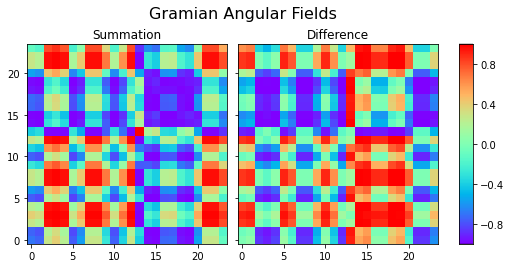

In [ ]:
# Show the images for the first time series
fig = plt.figure(figsize=(8, 4))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 2),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.3,
                 )
images = [X_gasf[0], X_gadf[0]]
titles = ['Summation', 'Difference']
for image, title, ax in zip(images, titles, grid):
    im = ax.imshow(image, cmap='rainbow', origin='lower')
    ax.set_title(title, fontdict={'fontsize': 12})
ax.cax.colorbar(im)
ax.cax.toggle_label(True)
plt.suptitle('Gramian Angular Fields', y=0.98, fontsize=16)
plt.show()

In [ ]:
def weights_init(m):
    if hasattr(m, 'weight'):
        m.weight.data.uniform_(-0.5, 0.5).float()
    if hasattr(m, 'bias'):
        m.weight.data.uniform_(-0.5, 0.5).float()

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.float()

        self.fc = nn.Sequential(
            nn.Linear(36, 10)
        )
        self.float()

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

net1 = LeNet().to(device)
net1.apply(weights_init)


LeNet(
  (body): Sequential(
    (0): Conv2d(1, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): Sigmoid()
    (2): Conv2d(12, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): Sigmoid()
    (4): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Sigmoid()
    (6): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): Sigmoid()
  )
  (fc): Sequential(
    (0): Linear(in_features=36, out_features=10, bias=True)
  )
)

In [ ]:
b = torch.from_numpy(X_gadf).float()

In [ ]:
b.dtype

torch.float32

In [ ]:
num_classes = 10
K = torch.tensor([2])

out = net1(b)

gt_onehot_label = label_to_onehot1(K, num_classes)

score = criterion(out, gt_onehot_label)

dy_dx = torch.autograd.grad(score, net1.parameters())

original_dy_dx = list((_.detach().clone() for _ in dy_dx))

Dummy label is 7.


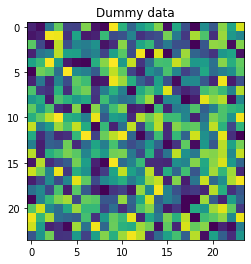

In [ ]:
# generate dummy data and label
tt = transforms.ToPILImage()

dummy_data = torch.randn(b.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

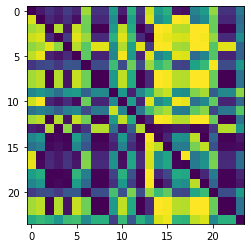

In [ ]:
plt.imshow(tt(b.cpu()))

In [ ]:
optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

history = []
for iters in range(301):
    def closure():
        optimizer.zero_grad()

        pred = net1(dummy_data) 
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net1.parameters(), create_graph=True)
        
        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()
        # grad_diff = grad_diff / grad_count * 1000
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    if iters % 10 == 0: 
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
    history.append(tt(dummy_data[0].cpu()))

0 0.0075
10 0.0000
20 0.0000
30 0.0000
40 0.0000
50 0.0000
60 0.0000
70 0.0000
80 0.0000
90 0.0000
100 0.0000
110 0.0000
120 0.0000
130 0.0000
140 0.0000
150 0.0000
160 0.0000
170 0.0000
180 0.0000
190 0.0000
200 0.0000
210 0.0000
220 0.0000
230 0.0000
240 0.0000
250 0.0000
260 0.0000
270 0.0000
280 0.0000
290 0.0000
300 0.0000


In [ ]:
b

In [ ]:
dummy_data[0]

Dummy label is 2.


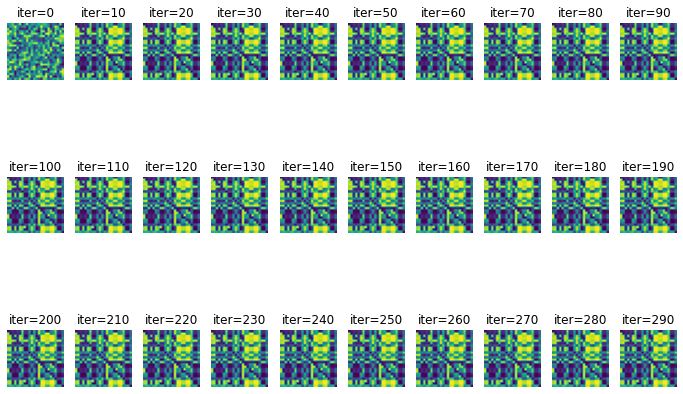

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(30):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[i * 10])
  plt.title("iter=%d" % (i * 10))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

Text(0.5, 1.0, 'The original image after conversion')

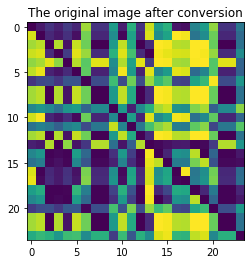

In [ ]:
plt.imshow(tt(b.cpu()))
plt.title("The original image after conversion")

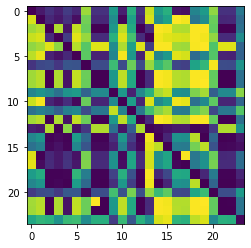

In [ ]:
plt.imshow(history[200])


In [ ]:
j = b[0][0]
k = dummy_data[0][0]
j = j.detach().numpy()
k = k.detach().numpy()

In [ ]:
l = range(len(j))

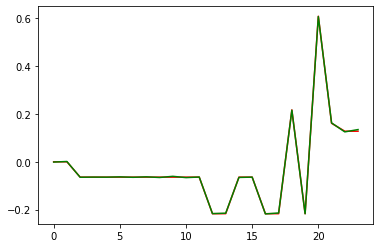

In [ ]:
plt.plot(l,j,color = 'r')
plt.plot(l,k,color = 'g')

In [ ]:
m = j - k

In [ ]:
m

array([ 1.1687713e-03, -1.2154876e-03,  4.7449768e-04, -8.9682639e-05,
        1.7254055e-04, -1.1305958e-03,  7.1460754e-04, -1.2604892e-03,
        1.4613271e-03, -3.3897832e-03,  1.9778609e-03, -4.3755770e-04,
       -3.2995641e-04, -2.1284968e-03,  1.2275353e-03, -3.5911798e-06,
        9.6079707e-04, -2.9908270e-03,  1.3042688e-03,  3.6981702e-04,
        1.1557937e-03, -1.6444027e-03,  2.7419180e-03, -6.8658739e-03],
      dtype=float32)

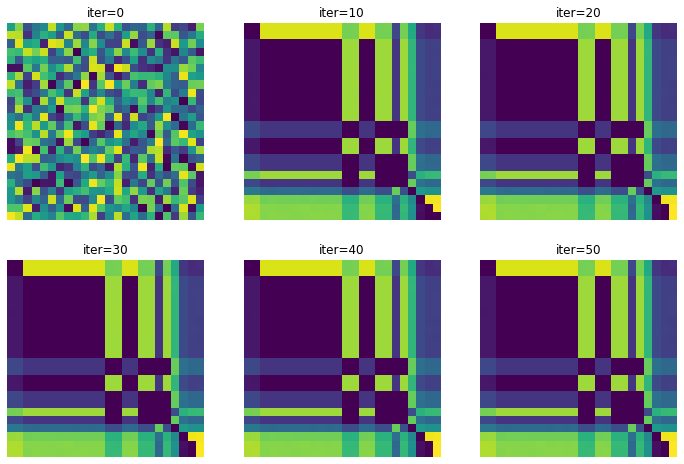

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(6):
  plt.subplot(2, 3, i + 1)
  plt.imshow(history[i * 10])
  plt.title("iter=%d" % (i * 10))
  plt.axis('off')
